<div style="display: flex; align-items: center; width: 100%;">  
  <div style="display: flex; flex-direction: column; align-items: center; justify-content: center; width: 100px; margin-right: 0px;">    
    <a href="https://risklab.ai" style="border: 0; line-height: 0.5;">
      <img src="../../utils/risklab_ai.gif" width="60px" style="border: 0; margin-bottom:-10px; vertical-align: middle;"/>
    </a>
  </div>  
  <div style="flex-grow: 1;">
    <h1 style="margin: 0; margin-left:0; font-weight: bold; text-align: left; font-size: 38px;">
      Introduction to Microstructural Features
    </h1>
  </div>  
</div>

This notebook demonstrates how to estimate microstructural features like the bid-ask spread and volatility using the RiskLabAI library.

These features are considered "first-generation" methods as they are derived directly from price data (High, Low, Close) to estimate market properties like illiquidity and volatility.

In this tutorial, we will:
* Connect to the FRED API to load public economic data.
* **Simulate** High, Low, and Close (HLC) data, as FRED does not provide HLC prices.
* Calculate the intermediate `beta` and `gamma` components from our simulated data.
* Estimate the **Corwin-Schultz Spread** using the `corwin_schultz_estimator` function.
* Estimate the **Bekker-Parkinson Volatility** using the `bekker_parkinson_volatility_estimates` function.
* Visualize all components to confirm the code runs.

## 0. Setup and Imports

First, we import our libraries and the necessary modules from `RiskLabAI`.

In [4]:
# Standard Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from fredapi import Fred
from dotenv import load_dotenv

# RiskLabAI Imports
import RiskLabAI.features.microstructural_features as msf
import RiskLabAI.utils.publication_plots as pub_plots

# --- Notebook Configuration ---

# Global Plotting Settings
SAVE_PLOTS = False  
PLOT_THEME = 'dark' # Options: 'light', 'medium'. 'dark', 'light-transparent'
PLOT_QUALITY = 300  
SAVE_DIR = 'figs'    

pub_plots.setup_publication_style(
    theme=PLOT_THEME,
    quality=PLOT_QUALITY,
    save_plots=SAVE_PLOTS,
    save_dir=SAVE_DIR
)

Matplotlib style updated. Theme: 'dark', Quality: 300 DPI.
Plot saving disabled.


## 1. Load Data (FRED)

As requested, we will connect to the FRED database. We'll load the S&P 500 Index (`SP500`) as our base series.

In [5]:
# This finds the .env file and loads FRED_API_KEY into os.environ
load_dotenv()

FRED_API_KEY = os.environ.get('FRED_API_KEY')

# To run the code on your computer, register for a free FRED API, 
# create a .env file, and add the line: FRED_API_KEY='YOUR_KEY_HERE'
# Alternatively, uncomment the following line and paste your key:
# FRED_API_KEY = 'YOUR_FRED_API_KEY'

if FRED_API_KEY is None:
    print("Warning: FRED_API_KEY not found. Please set it in your .env file.")
    fred = None
else:
    print("FRED API Key loaded.")
    fred = Fred(api_key=FRED_API_KEY)
    
data = pd.DataFrame()

if fred:
    # Fetch S&P 500 data (which is 'Close' only)
    close_prices = fred.get_series('SP500', start_date="2010-01-01", end_date="2023-01-01")
    close_prices = close_prices.dropna()
    data['Close'] = close_prices
    print("Successfully loaded 'SP500' data from FRED:")
    print(data.tail())
else:
    print("FRED API key not available. Notebook cannot proceed.")

FRED API Key loaded.
Successfully loaded 'SP500' data from FRED:
              Close
2025-11-10  6832.43
2025-11-11  6846.61
2025-11-12  6850.92
2025-11-13  6737.49
2025-11-14  6734.11


## 2. Data Preparation (Simulating HLC Data)

> **⚠️ Important Data Warning:**
> 
> The `corwin_schultz` and `bekker_parkinson` estimators **require daily High, Low, and Close (HLC) prices** to function.
> 
> The FRED database (as requested) provides 'Close'-only values for the `SP500` series. To demonstrate the *functionality* of the `RiskLabAI` library, we must **simulate** HLC data. 
> 
> **The HLC prices below are not real.** The resulting spread and volatility estimates are purely for code demonstration and have no real-world analytical value.

In [6]:
if not data.empty:
    # Simulate HLC data
    # We create a random high/low range for demonstration
    np.random.seed(42)
    data['High'] = data['Close'] * (1 + np.random.uniform(0.001, 0.015, size=len(data)))
    data['Low'] = data['Close'] * (1 - np.random.uniform(0.001, 0.015, size=len(data)))
    
    # Ensure High > Low and High >= Close, Low <= Close
    data['High'] = data[['High', 'Low', 'Close']].max(axis=1)
    data['Low'] = data[['High', 'Low', 'Close']].min(axis=1)

    high_prices = data['High']
    low_prices = data['Low']
    close_prices = data['Close']
    
    print("Simulated HLC data:")
    print(data.tail())
else:
    print("No data loaded from FRED. Cannot simulate HLC prices.")

Simulated HLC data:
              Close         High          Low
2025-11-10  6832.43  6845.236750  6775.131659
2025-11-11  6846.61  6938.138952  6814.946758
2025-11-12  6850.92  6900.770492  6839.002320
2025-11-13  6737.49  6792.373963  6662.264658
2025-11-14  6734.11  6799.917711  6715.939742


## 3. Intermediate Components (Beta and Gamma)

Now we can use our **simulated** HLC data to test the intermediate functions from the `RiskLabAI` module.

In [7]:
if not data.empty:
    window_span = 20
    print(f"Calculating Beta and Gamma with window: {window_span} days")
    
    # Calculate Beta
    beta = msf.beta_estimates(high_prices, low_prices, window_span)
    beta.name = "Beta"
    
    # Calculate Gamma
    gamma = msf.gamma_estimates(high_prices, low_prices)
    gamma.name = "Gamma"
    
    print("Calculation complete.")
    print("\nBeta (tail):")
    print(beta.tail())

Calculating Beta and Gamma with window: 20 days
Calculation complete.

Beta (tail):
2025-11-10    0.000680
2025-11-11    0.000687
2025-11-12    0.000664
2025-11-13    0.000652
2025-11-14    0.000662
Name: Beta, dtype: float64


## 4. Corwin-Schultz Spread (Alpha and S)

Next, we demonstrate the `alpha_estimates` function and the high-level `corwin_schultz_estimator` wrapper. Both will produce identical (simulated) results.

In [8]:
if not data.empty:
    print("Calculating Alpha and Corwin-Schultz Spread...")

    # 1. Calculate Alpha using the intermediate components
    alpha = msf.alpha_estimates(beta, gamma)
    alpha.name = "Alpha"

    # 2. Calculate Spread (S) from Alpha
    spread_cs = 2 * (np.exp(alpha) - 1) / (1 + np.exp(alpha))
    spread_cs.name = "Corwin-Schultz Spread"

    print("Calculation complete.")
    print("\nAlpha (tail):")
    print(alpha.tail())
    
    # --- We can also use the high-level wrapper ---
    spread_wrapper = msf.corwin_schultz_estimator(high_prices, low_prices, window_span=window_span)
    print("\nWrapper function (tail) - results should match:")
    print(spread_wrapper.tail())

Calculating Alpha and Corwin-Schultz Spread...
Calculation complete.

Alpha (tail):
2025-11-10    0.000000
2025-11-11    0.005859
2025-11-12    0.018960
2025-11-13    0.000000
2025-11-14    0.012728
Name: Alpha, dtype: float64

Wrapper function (tail) - results should match:
2025-11-10    0.000000
2025-11-11    0.005859
2025-11-12    0.018959
2025-11-13    0.000000
2025-11-14    0.012728
dtype: float64


## 5. Bekker-Parkinson Volatility Estimator

Finally, we demonstrate the `sigma_estimates` and `bekker_parkinson_volatility_estimates` functions.

In [9]:
if not data.empty:
    print("Calculating Bekker-Parkinson Volatility (Sigma)...")

    # Calculate Sigma (volatility) using the intermediate components
    vol_bp = msf.sigma_estimates(beta, gamma)
    vol_bp.name = "Bekker-Parkinson Volatility"

    print("Calculation complete.")
    print(vol_bp.tail())

    # --- We can also use the high-level wrapper ---
    vol_wrapper = msf.bekker_parkinson_volatility_estimates(high_prices, low_prices, window_span=window_span)
    print("\nWrapper function (tail) - results should match:")
    print(vol_wrapper.tail())

Calculating Bekker-Parkinson Volatility (Sigma)...
Calculation complete.
2025-11-10    0.110286
2025-11-11    0.099225
2025-11-12    0.089315
2025-11-13    0.114845
2025-11-14    0.093041
Name: Bekker-Parkinson Volatility, dtype: float64

Wrapper function (tail) - results should match:
2025-11-10    0.110286
2025-11-11    0.099225
2025-11-12    0.089315
2025-11-13    0.114845
2025-11-14    0.093041
dtype: float64


## 6. Visualization

We can now plot our **simulated** results to confirm the code runs. The patterns here are driven by our random number generator in Step 2, not by real market dynamics.

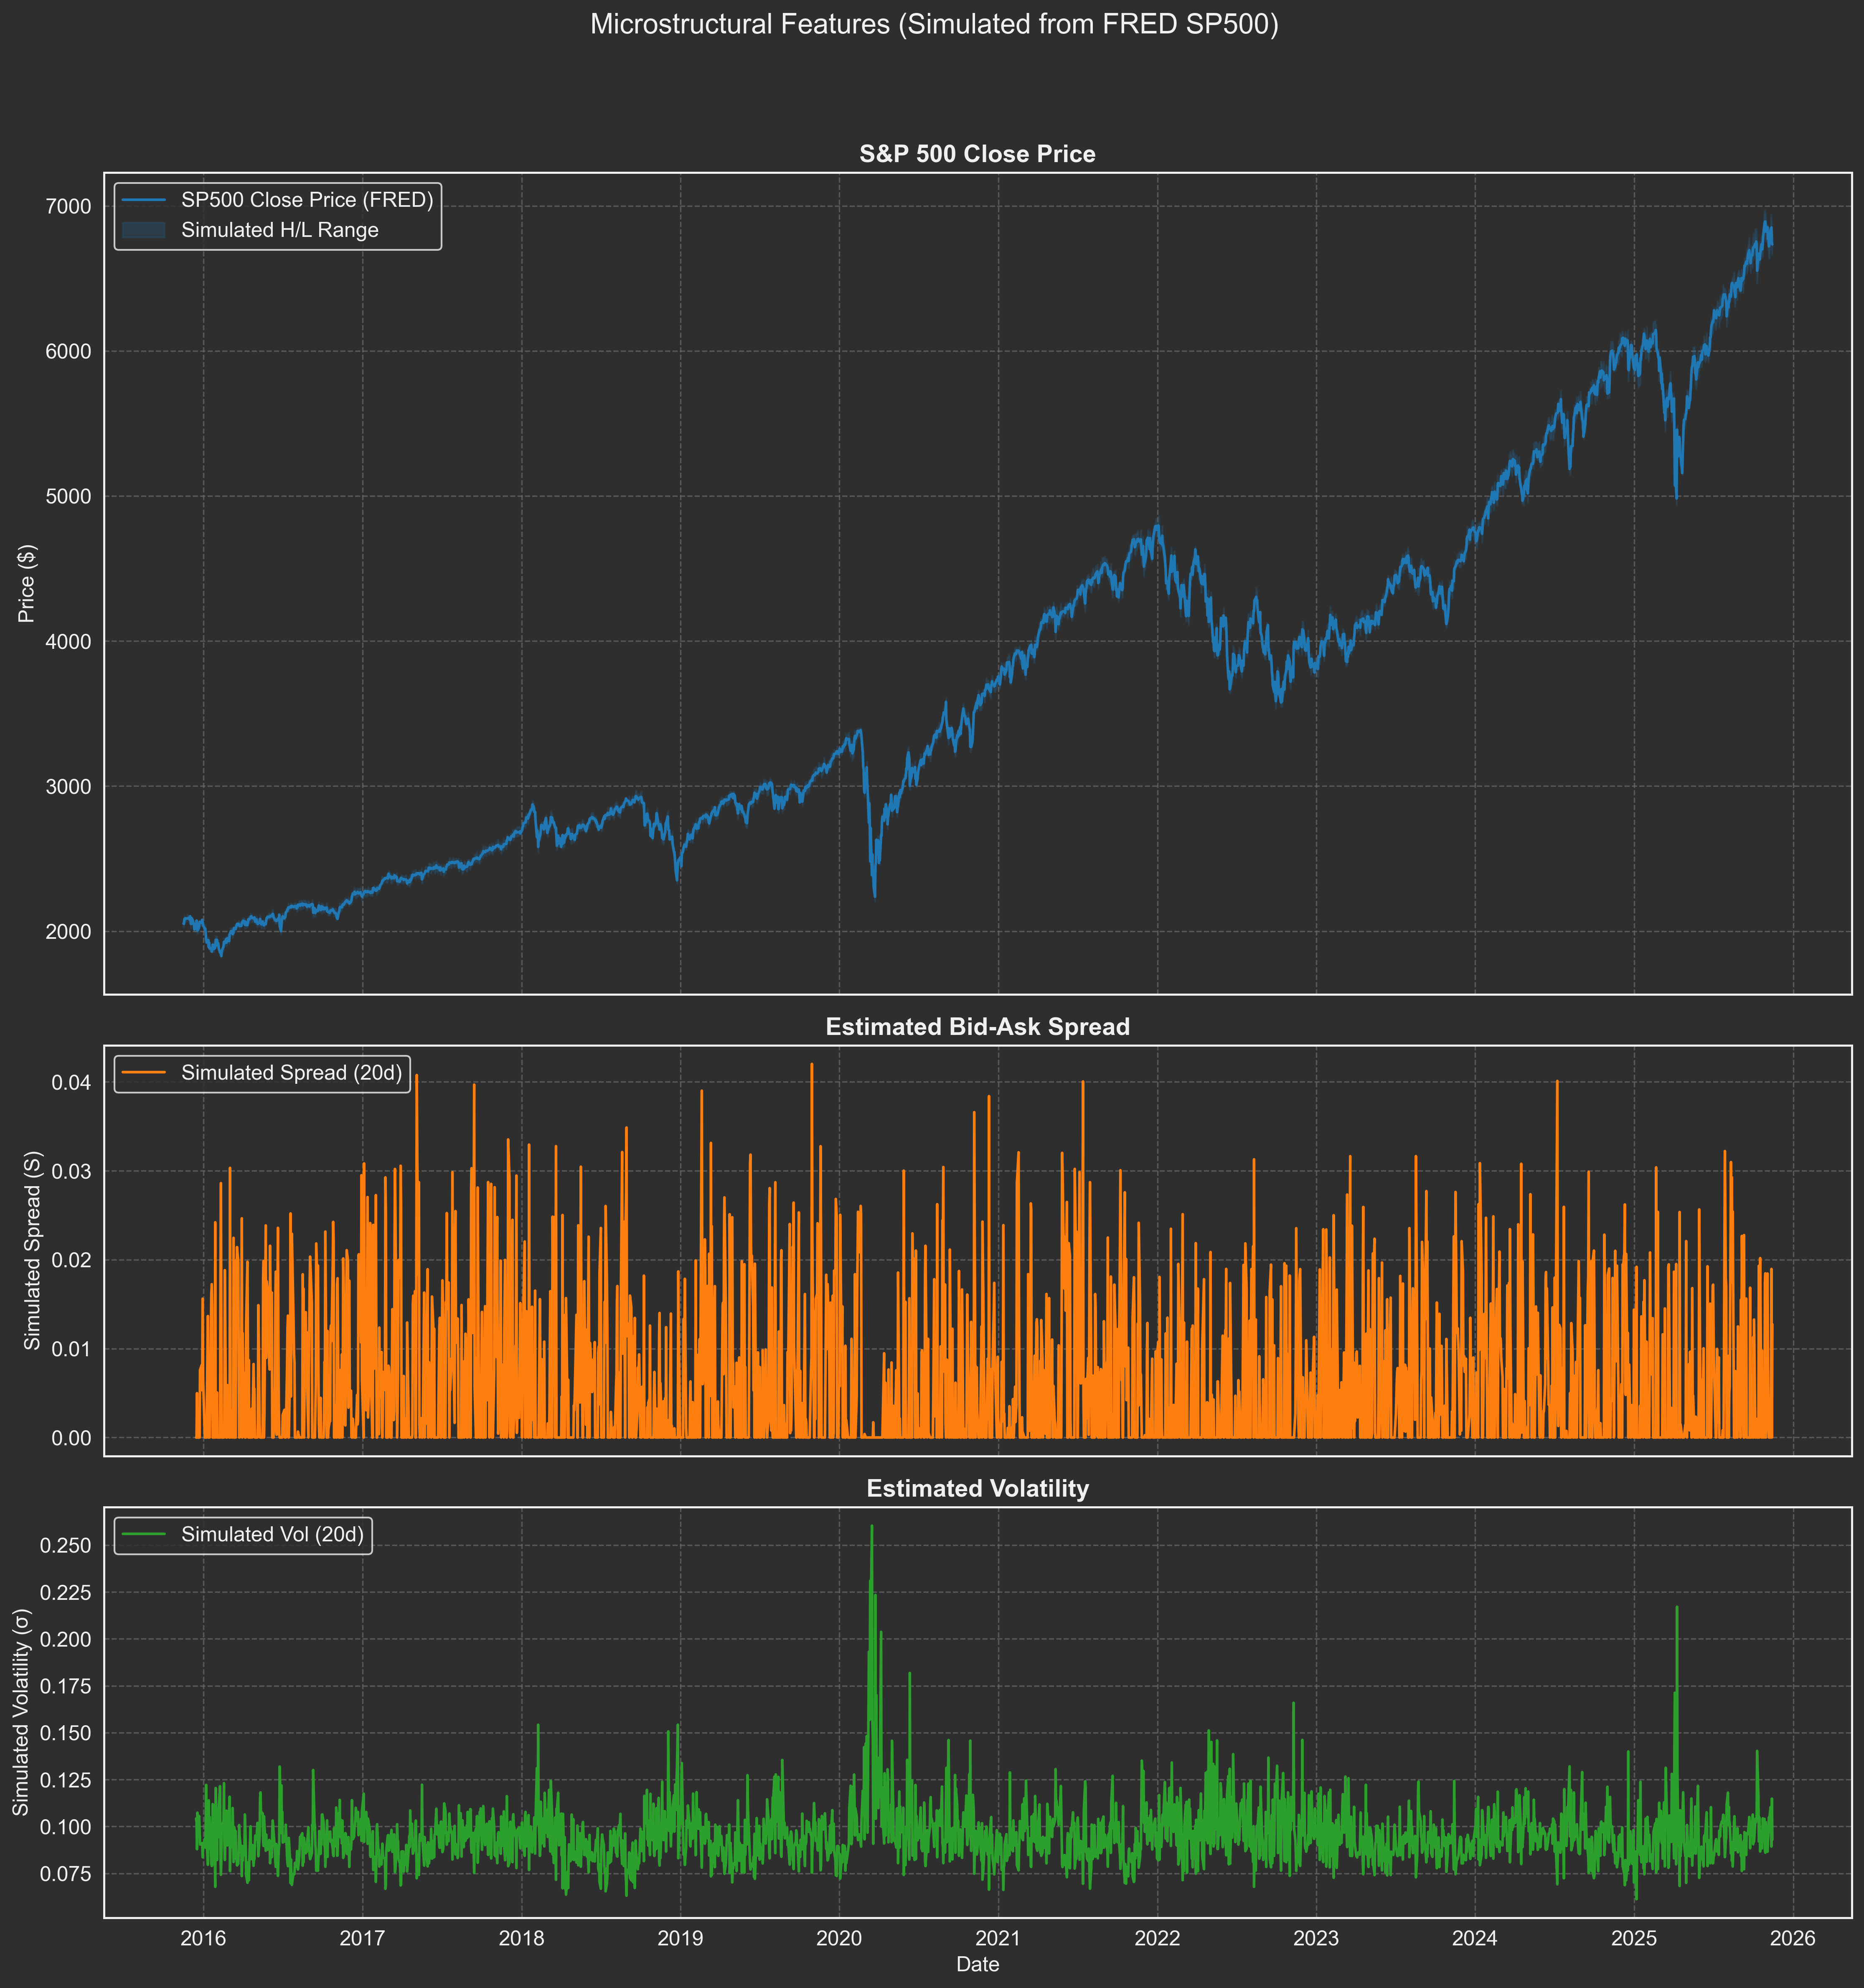

In [10]:
if not data.empty:
    fig, (ax1, ax2, ax3) = plt.subplots(
        3, 1, 
        figsize=(15, 16), 
        sharex=True, 
        gridspec_kw={'height_ratios': [2, 1, 1]}
    )
    fig.suptitle('Microstructural Features (Simulated from FRED SP500)', fontsize=16, y=1.02)

    # --- Panel 1: Price ---
    ax1.plot(close_prices.index, close_prices, label='SP500 Close Price (FRED)', color='C0', lw=1.5)
    ax1.fill_between(data.index, low_prices, high_prices, color='C0', alpha=0.2, label='Simulated H/L Range')
    pub_plots.apply_plot_style(ax1, 'S&P 500 Close Price', '', 'Price ($)')
    ax1.legend(loc='upper left')

    # --- Panel 2: Spread ---
    ax2.plot(spread_cs.index, spread_cs, label='Simulated Spread (20d)', color='C1', lw=1.5)
    pub_plots.apply_plot_style(ax2, 'Estimated Bid-Ask Spread', '', 'Simulated Spread (S)')
    ax2.legend(loc='upper left')

    # --- Panel 3: Volatility ---
    ax3.plot(vol_bp.index, vol_bp, label='Simulated Vol (20d)', color='C2', lw=1.5)
    pub_plots.apply_plot_style(ax3, 'Estimated Volatility', 'Date', 'Simulated Volatility (σ)')
    ax3.legend(loc='upper left')

    plt.tight_layout(rect=[0, 0.03, 1, 0.99])

    # Use finalize_plot to show and save the figure (if enabled)
    pub_plots.finalize_plot(fig, 'microstructural_features.png')
else:
    print("Cannot generate plots. No data was loaded.")